In [1]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import xarray as xr
import skgstat as skg
from skgstat import models
import gstatsim as gsm
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc
from sklearn.preprocessing import QuantileTransformer
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers
import warnings

import sys
sys.path.append('..')

import gstatsim_custom as gsim



In [2]:
ds = xr.load_dataset('test_data.nc')
#ds = ds.coarsen(x=2, y=2, boundary='trim').mean()
ds

<xarray.Dataset> Size: 4MB
Dimensions:                 (x: 200, y: 300)
Coordinates:
  * x                       (x) float32 800B -1.25e+06 -1.249e+06 ... -1.15e+06
  * y                       (y) float32 1kB -7.502e+05 -7.508e+05 ... -8.998e+05
Data variables: (12/14)
    surface_topography      (y, x) float32 240kB 1.985e+03 ... 2.275e+03
    bed_uncertainty         (y, x) float32 240kB 153.0 151.0 ... 167.0 163.0
    bed_topography          (y, x) float32 240kB 15.0 61.0 ... -353.0 -319.0
    mask                    (y, x) float32 240kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ice_thickness           (y, x) float32 240kB 1.97e+03 ... 2.594e+03
    thickness_survey_count  (y, x) float32 240kB nan nan nan nan ... nan nan nan
    ...                      ...
    geoid                   (y, x) float64 480kB -35.0 -35.0 ... -38.0 -38.0
    bed_ell                 (y, x) float64 480kB -20.0 26.0 ... -391.0 -357.0
    surface_ell             (y, x) float64 480kB 1.95e+03 ... 2.237e+03
    thick_cond              (y, x) float64 480kB nan nan nan nan ... nan nan nan
    vx                      (y, x) float32 240kB -5.393 -3.659 ... 2.892 2.983
    vy                      (y, x) float32 240kB 14.38 14.35 ... 5.464 5.648
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [3]:
bed_cond = ds.surface_topography.values - ds.thick_cond.values
xx, yy = np.meshgrid(ds.x, ds.y)

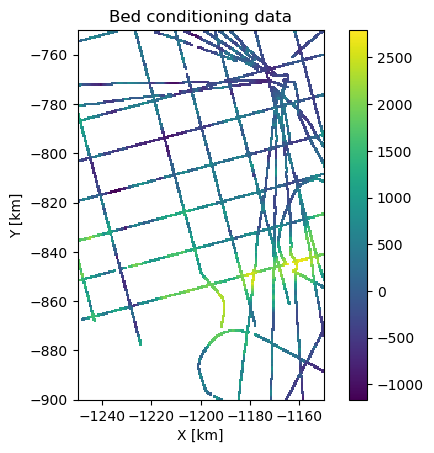

In [4]:
plt.pcolormesh(ds.x/1000, ds.y/1000, bed_cond)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar()
plt.show()

In [5]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]

In [6]:
%%time
smoothing = 1e11
interp = RBFInterpolator(np.array([x_cond, y_cond]).T, data_cond, smoothing=smoothing)
trend = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
res_cond = bed_cond - trend

CPU times: user 44.6 s, sys: 312 ms, total: 44.9 s
Wall time: 6.35 s


**Let's try to get this cell sped up with GPU. First put the array on the GPU, then run the new cupy interpolate.**

In [7]:
import numpy as np
import cupy as cp
from cupyx.scipy.interpolate import RBFInterpolator as GPU_RBFInterpolator

# Original parameters
smoothing = 1e11
# Convert numpy arrays to cupy arrays (move to GPU)
x_cond_gpu = cp.asarray(x_cond).astype(cp.float64)
y_cond_gpu = cp.asarray(y_cond).astype(cp.float64)
data_cond_gpu = cp.asarray(data_cond).astype(cp.float64)
xx_gpu = cp.asarray(xx).astype(cp.float64)
yy_gpu = cp.asarray(yy).astype(cp.float64)
bed_cond_gpu = cp.asarray(bed_cond).astype(cp.float64)

# Create coordinate pairs on GPU
coords_gpu = cp.stack([x_cond_gpu, y_cond_gpu], axis=1)

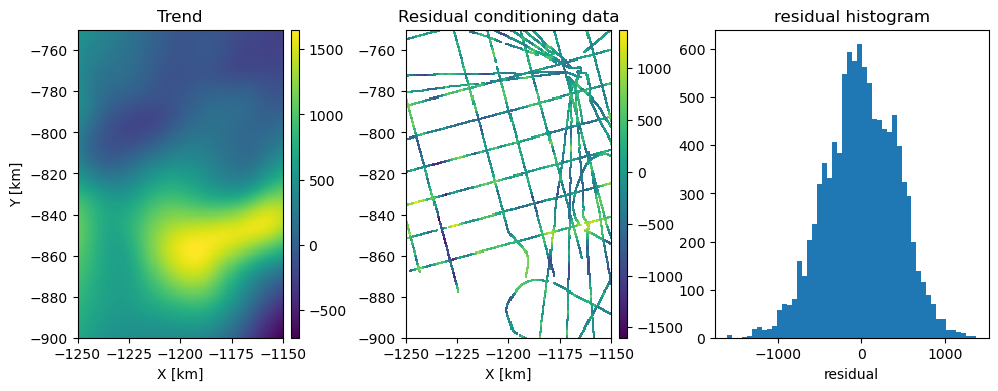

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, res_cond)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Residual conditioning data')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()

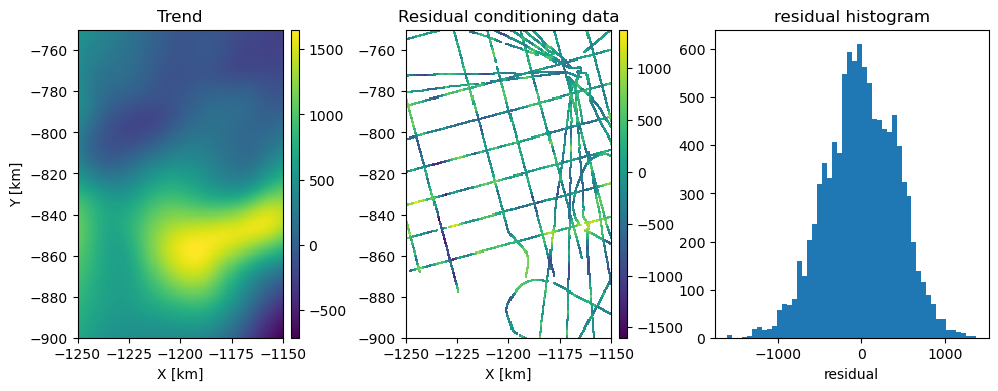

CPU times: user 729 ms, sys: 203 ms, total: 932 ms
Wall time: 1.41 s


In [9]:
%%time
# === GPU interpolation ===
interp = GPU_RBFInterpolator(coords_gpu, data_cond_gpu, smoothing=smoothing)

# Create query points on GPU
query_points = cp.stack([xx_gpu.flatten(), yy_gpu.flatten()], axis=1)

# Perform interpolation on GPU
trend_gpu = interp(query_points).reshape(xx_gpu.shape)

# Calculate residuals on GPU
res_cond_gpu = bed_cond_gpu - trend_gpu

# Convert results to CPU for plotting
trend = cp.asnumpy(trend_gpu)
res_cond = cp.asnumpy(res_cond_gpu)

# === Plot results ===
fig, axs = plt.subplots(1, 3, figsize=(12,4))

# Plot trend
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

# Plot residual conditioning data
ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, res_cond)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Residual conditioning data')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

# Plot residual histogram (only where condition mask is True)
ax = axs[2]
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()


In [10]:
%%time
res_norm, nst_trans = gsim.utilities.gaussian_transformation(res_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : res_cond[cond_msk], 'NormZ' : res_norm[cond_msk]})

CPU times: user 3.14 ms, sys: 1.92 ms, total: 5.06 ms
Wall time: 7.46 ms


In [11]:
%%time
vgrams, experimental, bins = gsim.utilities.variograms(xx, yy, res_cond, maxlag=30e3, n_lags=20, downsample=10)

CPU times: user 646 ms, sys: 82.4 ms, total: 729 ms
Wall time: 1.06 s


In [12]:
import cudf 
from gstatsim_custom import utilities_gpu

In [13]:
%%time
cond_msk_gpu = cp.asarray(cond_msk)
res_norm_gpu, nst_trans_gpu = utilities_gpu.gaussian_transformation_gpu(res_cond_gpu, cond_msk_gpu)
cudf_grid = cudf.DataFrame({'X' : x_cond_gpu, 'Y' : y_cond_gpu, 'residual' : res_cond_gpu[cond_msk_gpu], 'NormZ' : res_norm_gpu[cond_msk_gpu]})

CPU times: user 72.3 ms, sys: 12.1 ms, total: 84.4 ms
Wall time: 203 ms


In [14]:
%%time
#vgrams_gpu, experimental_gpu, bins_gpu = utilities_gpu.variograms_gpu(xx_gpu, yy_gpu, res_cond_gpu, maxlag=30e3, n_lags=20, downsample=10)
vgrams_gpu, experimental_gpu, bins_gpu = utilities_gpu.variograms_gpu(xx_gpu, yy_gpu, res_cond_gpu, maxlag=30e3, n_lags=20, downsample=10)

CPU times: user 108 ms, sys: 10.9 ms, total: 119 ms
Wall time: 121 ms


In [15]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

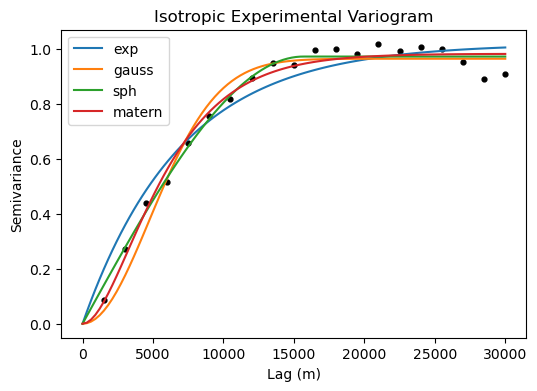

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [17]:
vgrams['matern']

[np.float64(15174.871583106875),
 np.float64(0.9839169461135034),
 np.float64(1.617637130268195),
 0]

In [18]:
vgrams_gpu['matern']

[np.float64(15175.118670031361),
 np.float64(0.9870630577534463),
 np.float64(1.6150946723388706),
 0]

In [19]:
parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

In [20]:
rng = np.random.default_rng(0)

k = 20
rad = 50e3

In [21]:
parameters_gpu = vgrams_gpu['matern']

# set variogram parameters
nugget_gpu = parameters_gpu[-1]
major_range_gpu = parameters_gpu[0]
minor_range_gpu = parameters_gpu[0]
sill_gpu = parameters_gpu[1]
smoothness_gpu = parameters_gpu[2]
nugget_gpu = parameters_gpu[-1]
azimuth_gpu = 0



# New GStatSim variant is faster

* Changed to variogram being a dictionary so that the order does not matter
* The new sgs function takes the grid with conditioning data in it and NaN elsewhere. Does not use pandas DataFrame

In [22]:
!nvidia-smi

/apps/lmod/lmod/init/bash: line 26: /apps/lmod/8.7.60/libexec/addto: cannot execute: required file not found
Thu Aug 28 13:22:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA B200                    On  |   00000000:43:00.0 Off |                    0 |
| N/A   28C    P0            187W / 1000W |    5076MiB / 183359MiB |      0%      Default |
|                              

In [23]:
from gstatsim_custom import interpolate_gpu
del vgrams_gpu, experimental_gpu, bins_gpu
del trend_gpu, x_cond_gpu, y_cond_gpu,data_cond_gpu,bed_cond_gpu,coords_gpu

# Clear the memory pool
cp.get_default_memory_pool().free_all_blocks()

In [24]:
%%time
vario_gpu = {
    'azimuth' : azimuth_gpu,
    'nugget' : nugget_gpu,
    'major_range' : major_range_gpu,
    'minor_range' : minor_range_gpu,
    'sill' : sill_gpu,
    's' : smoothness_gpu,
    'vtype' : 'matern',
}

#res_newsim_gpu = interpolate_gpu.sgs_gpu(xx_gpu, yy_gpu, res_cond_gpu, vario_gpu, max_memory_gb=24.0, seed=0)

res_newsim_gpu = interpolate_gpu.sgs_gpu(
    xx_gpu, yy_gpu, res_cond_gpu, vario_gpu,
    radius=150e3,
    num_points=48,
    seed=0,
    batch_size=4096,  # Should be 8000-16000+
    quiet=False,
    max_memory_gb=150.0  # Use much more memory
)


SGS: 100%|██████████| 60000/60000 [00:14<00:00, 4243.49pts/s]

CPU times: user 10.3 s, sys: 2.35 s, total: 12.7 s
Wall time: 14.4 s


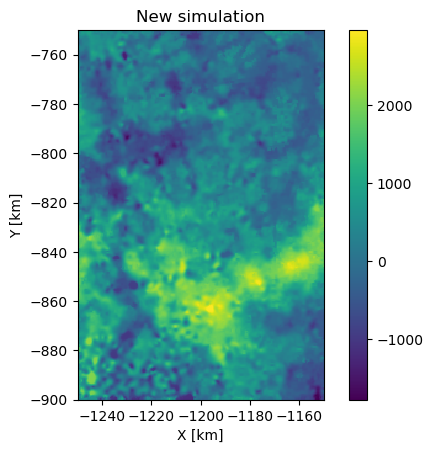

In [25]:
# Convert arrays to NumPy once
res_np = cp.asnumpy(res_newsim_gpu)
x_np   = cp.asnumpy(ds.x) / 1000
y_np   = cp.asnumpy(ds.y) / 1000

plt.pcolormesh(x_np, y_np, res_np + trend)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('New simulation')
plt.colorbar()
plt.show()

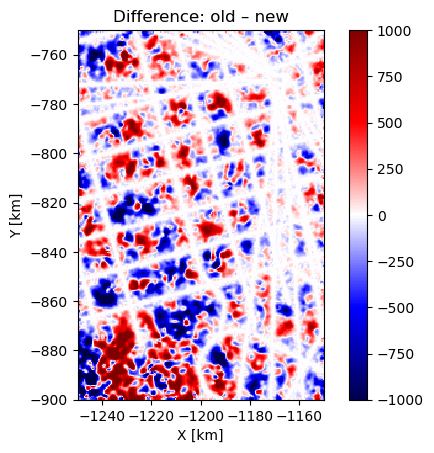

In [26]:
# one-liner
res_sim_gsm=np.load('/blue/vendor-nvidia/smith.kaleb/gstatsim_custom/res_sim_gsm.npy')

diff = cp.asnumpy(res_sim_gsm) - cp.asnumpy(res_newsim_gpu)

plt.pcolormesh(x_np, y_np, diff, vmin=-1000, vmax=1000, cmap='seismic')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Difference: old – new')
plt.colorbar()
plt.show()



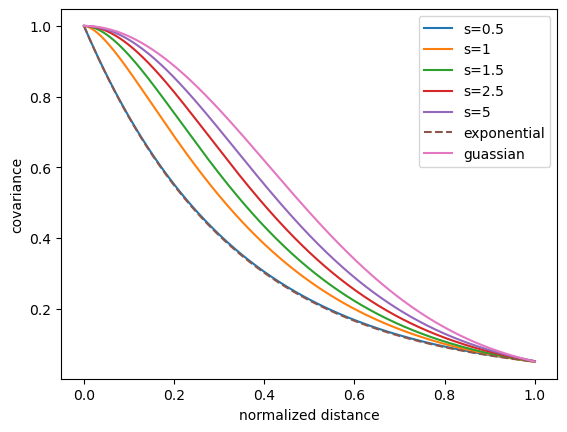

In [27]:
xi = np.linspace(0,1,1000)
xi_gpu = cp.linspace(0,1,1000)

y_exp = gsim.covariance_gpu.exponential_cov_norm_gpu(xi_gpu,1,0)
y_gau = gsim.covariance_gpu.gaussian_cov_norm_gpu(xi_gpu,1,0)

ss= [0.5, 1, 1.5, 2.5, 5]

for i,s in enumerate(ss):
    y=gsim.covariance_gpu.matern_cov_norm_gpu(xi_gpu, sill=1.0, nugget=0, s=s)
    plt.plot(xi, y.get(), '-', label=f's={s}')
    
plt.plot(xi, y_exp.get(), '--', label='exponential')
plt.plot(xi, y_gau.get(), label='guassian')
plt.xlabel('normalized distance')
plt.ylabel('covariance')
plt.legend()
plt.show()